In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import sklearn as sk
import math

In [3]:
dist = pd.read_csv('../dist_data.csv', sep=';')

In [4]:
dist_clean = dist[dist['dist'] != "[[], []]"]

In [5]:
x = dist_clean.iloc[:, :-1].values
y = dist_clean.iloc[:, 1].values

In [6]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.30)

In [7]:
def clean_sample(sample):
    sample_list = sample[0].replace(', [', '; [').split(';')
    sample_x = sample_list[0]
    sample_Px = sample_list[1]

    sample_x_list = []
    sample_Px_list = []
    
    for x in sample_x.split(','):
        sample_x_list.append(x.replace(' ', '').replace('[', '').replace(']', ''))
    for Px in sample_Px.split(','):
        sample_Px_list.append(Px.replace(' ', '').replace('[', '').replace(']', ''))

    dict_sample = {}
    for i in range(len(sample_x_list)):
        dict_sample[sample_x_list[i]] = sample_Px_list[i]
    return dict_sample


def preprocess_distros(distro1, distro2):
    label_distance = []
    for i, sample_x_test in enumerate(distro1):
        label_pre_distro = []
        for j, sample_x_train in enumerate(distro2):
            #distro1_with_all.append(aggregate_distro(clean_sample(sample_x_test), clean_sample(sample_x_train)))
            label_pre_distro.append([distro2_label[j], kl(aggregate_distro(clean_sample(sample_x_test), clean_sample(sample_x_train)))])
        label_distance.append(label_pre_distro)
        #print(label_distance)
    return label_distance


def aggregate_distro(distro1, distro2):
    xPQx_dict={}
    for xd1, Pxd1 in distro1.items():
        if xd1 == "" or Pxd1 == "":
            continue
        Pxd2 = distro2.get(xd1)
        if Pxd2 is None:
            Pxd2 = 0.0
        xPQx_dict.update({xd1:[Pxd1, Pxd2]})
                    
    for xd2, Pxd2 in distro2.items():
        if xd2 == "" or Pxd2 == "":
            continue
        Pxd1 = distro1.get(xd2)
        if Pxd1 is None:
            Pxd1 = 0.0
            xPQx_dict.update({xd2:[0.0, Pxd2]})
    
    return xPQx_dict



def kl(dict_distro):
    sum = 0 
    for i in dict_distro.values():
        Pi = float(i[0])
        Qi = float(i[1])
        if Pi == 0.0:
            sum += 0.0
            continue
        if Qi == 0.0:
            return 9999
        sum += float(Pi) * math.log10(float(Pi) / float(Qi))
        
    return sum

In [8]:
def Predict(label_distance, threshold):
    y_pred = []
    for i in range(len(final_distro)):
        t = pd.DataFrame(label_distance[i], columns=['Label', 'Kl Result'])
        tmp = t[t['Kl Result'] < threshold]
        tmp['Count'] = tmp.groupby(['Label']).transform('size')
        #tmp = tmp.sort_values(by=['Kl Result', 'Count'], ascending=[True, False])
        tmp = tmp.sort_values(by=['Count', 'Kl Result'], ascending=[False, True])
        if tmp.values.size == 0:
            y_pred.append(0)
        else:
            y_pred.append(tmp.head(1)['Label'].values[0])
            
    return y_pred

In [9]:
distro1 = x_test
distro1_label = y_test
distro2 = x_train
distro2_label = y_train

final_distro = preprocess_distros(distro1, distro2)


In [15]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

prediction = {}
for i in np.arange(1.5, 0.5, -0.05):
    #print(i)
    y_pred = Predict(final_distro, i)
    res1 = accuracy_score(y_test,y_pred)
    res2 = f1_score(y_test, y_pred, average="weighted")
    res3 = f1_score(y_test, y_pred, average="micro")
    res4 = f1_score(y_test, y_pred, average="macro")
    prediction[round(i,2)] = [res1, res2, res3, res4]


Max Accuracy is: 0.8179519595448799 and threshold is: 1.05
Max F1_weighted is: 0.843988602898413 and threshold is: 1.05
Max F1_micro is: 0.8179519595448799 and threshold is: 1.05
Max F1_macro is: 0.5670469898955293 and threshold is: 1.05


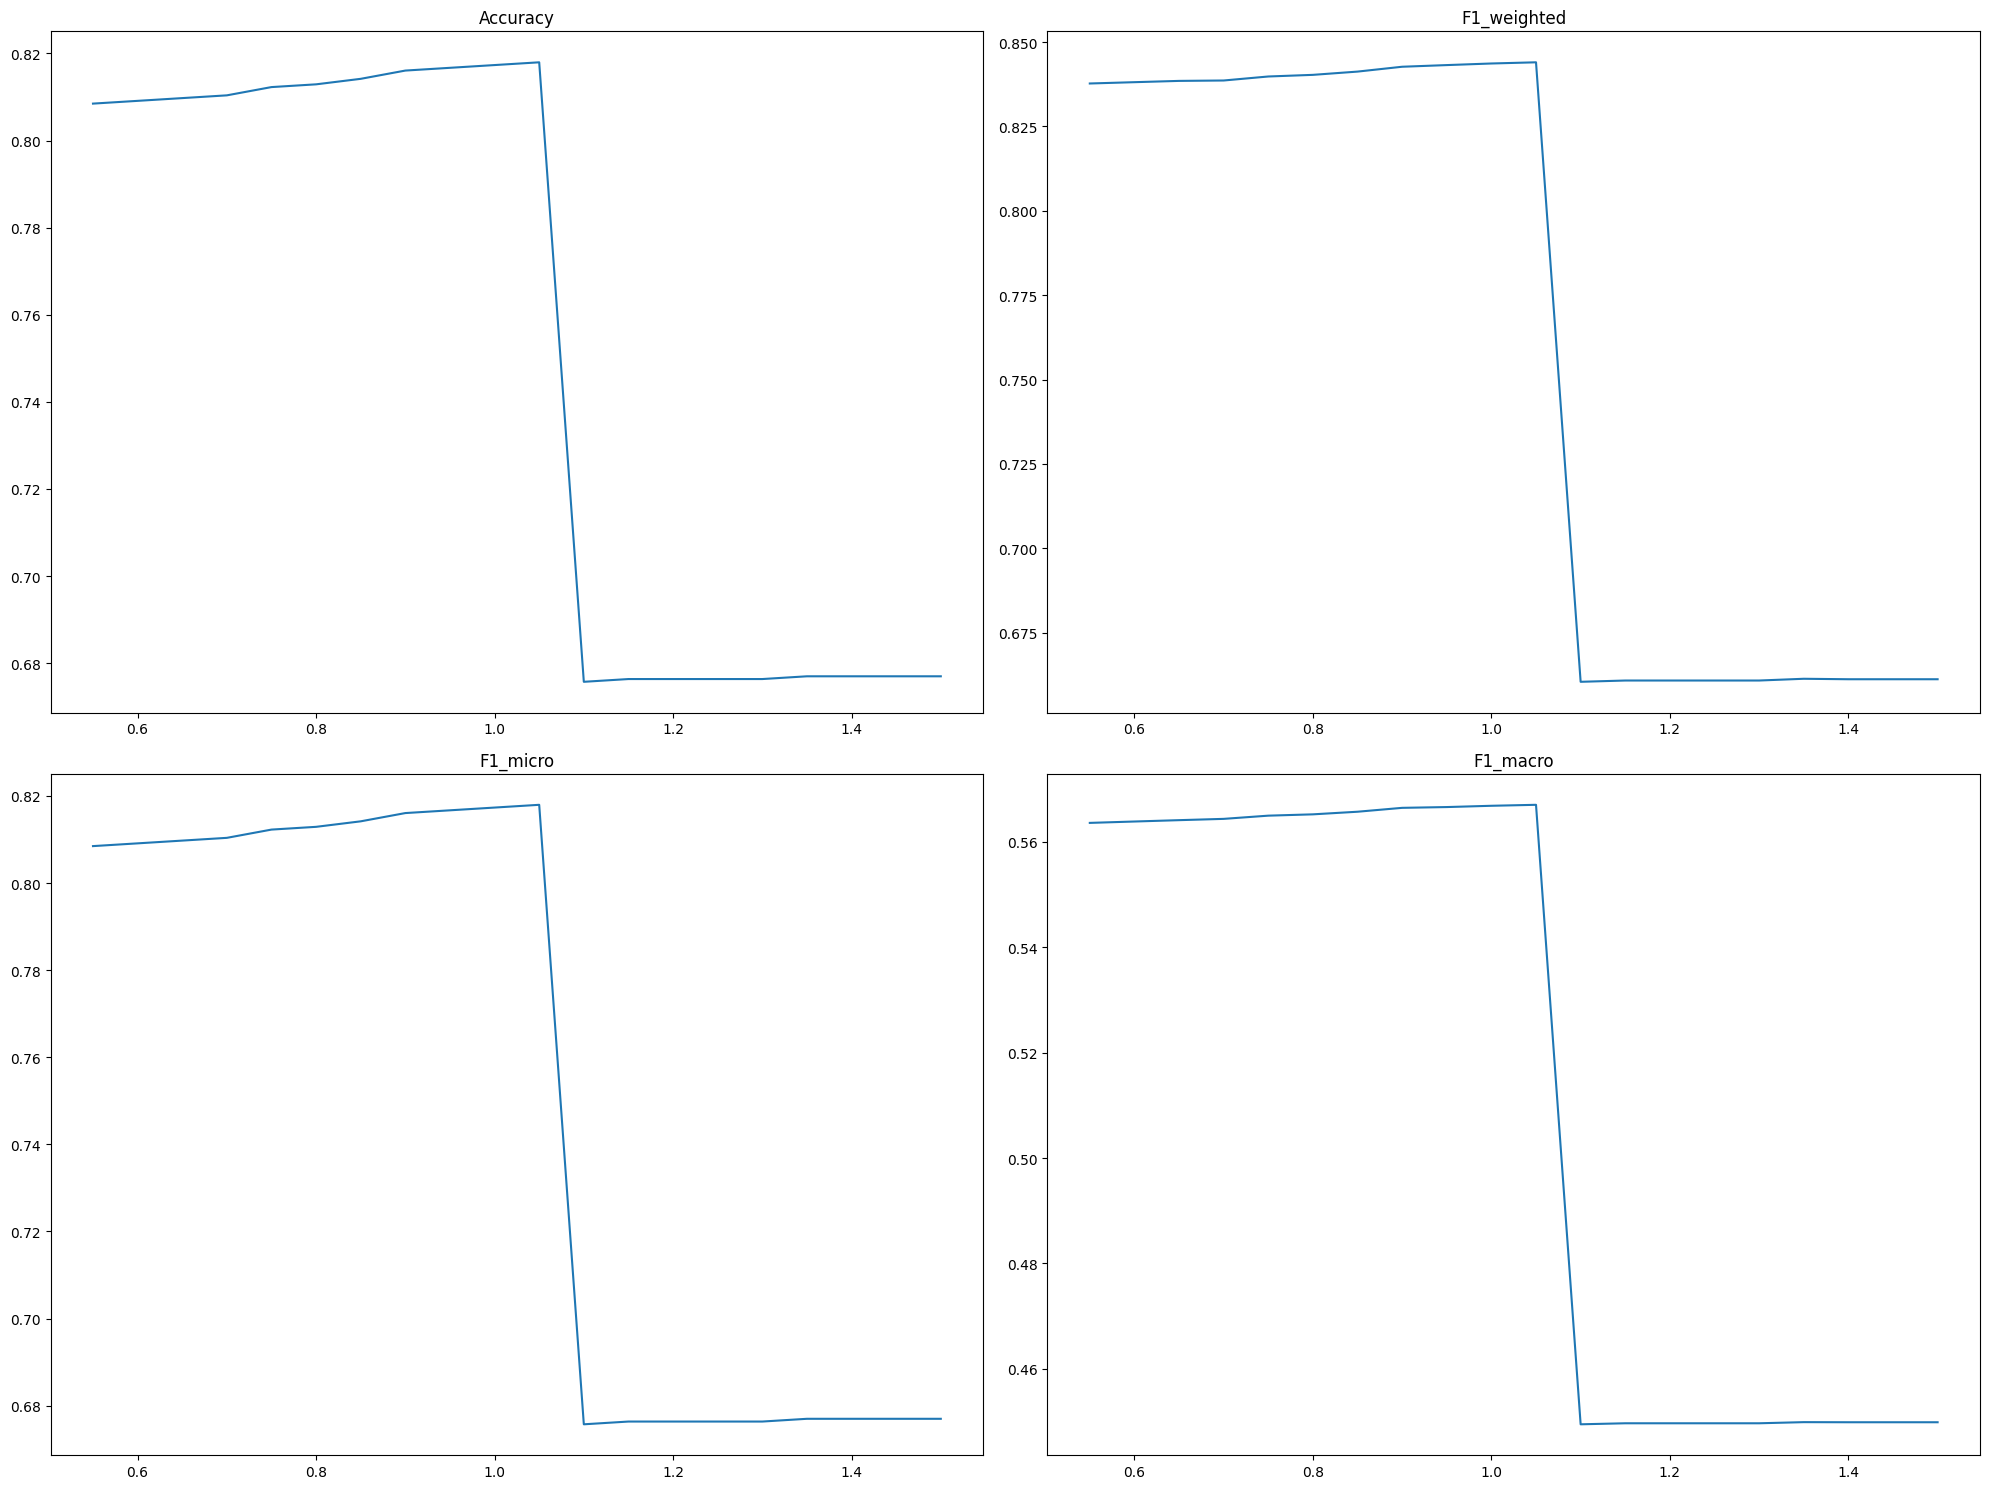

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.DataFrame.from_dict(prediction, orient='index', columns=['Accuracy', 'F1_weighted', 'F1_micro', 'F1_macro'])

fig, axx = plt.subplots(2, 2, figsize=(20,15))

axx[0, 0].set_title('Accuracy')
sns.lineplot(y=data['Accuracy'].values, x=data.index, ax=axx[0, 0])
print(f"Max Accuracy is: {data['Accuracy'].max()} and threshold is: {data[data['Accuracy'] == data['Accuracy'].max()].index[0]}")



axx[0, 1].set_title('F1_weighted')
sns.lineplot(y=data['F1_weighted'].values, x=data.index, ax=axx[0, 1])
print(f"Max F1_weighted is: {data['F1_weighted'].max()} and threshold is: {data[data['F1_weighted'] == data['F1_weighted'].max()].index[0]}")

axx[1, 0].set_title('F1_micro')
sns.lineplot(y=data['F1_micro'].values, x=data.index, ax=axx[1, 0])
print(f"Max F1_micro is: {data['F1_micro'].max()} and threshold is: {data[data['F1_micro'] == data['F1_micro'].max()].index[0]}")

axx[1, 1].set_title('F1_macro')
sns.lineplot(y=data['F1_macro'].values, x=data.index, ax=axx[1, 1])
print(f"Max F1_macro is: {data['F1_macro'].max()} and threshold is: {data[data['F1_macro'] == data['F1_macro'].max()].index[0]}")

plt.tight_layout()